# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
dataset, info = tfds.load('cats_vs_dogs', split=['train[:20%]', 'train[96%:]'],
                                         as_supervised=True, with_info=True)
train_ds, test_ds = dataset

## Printing information about the dataset

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, 

# Defining constants

In [4]:
IMAGE_SIZE: tuple[int, int] = (128, 128)
BATCH_SIZE: int = 32
INPUT_SHAPE: int = IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3
EPOCHS: int = 50

# Preprocessing

## Standardizing the dataset
- Resizing all images to `128 x 128`.
- Dividing by `255` to normalize to `[0, 1]` range.

In [5]:
def standardize(image, label):
  image = tf.image.resize(image, IMAGE_SIZE)  # Resize to IMAGE_SIZE
  image = image / 255.0                     # Standardize limits
  return image, label

train_ds = train_ds.map(standardize)
test_ds = test_ds.map(standardize)

## Converting images to `numpy.ndarray`

In [6]:
def tfds_to_numpy(dataset):
    images = [image for image, _ in dataset]
    labels = [label for _, label in dataset]
    return np.array(images), np.array(labels)

X_train, y_train = tfds_to_numpy(train_ds)
X_test, y_test = tfds_to_numpy(test_ds)

In [19]:
X_train

array([[[[0.9694609 , 0.99249387, 0.9851472 ],
         [0.86938   , 0.881166  , 0.87007266],
         [0.595971  , 0.59989256, 0.5776042 ],
         ...,
         [0.7540403 , 0.71297175, 0.53189003],
         [0.78160954, 0.7321916 , 0.55103356],
         [0.6097613 , 0.5705456 , 0.37054563]],

        [[0.94657123, 0.96617913, 0.9504928 ],
         [0.7309874 , 0.74351805, 0.7275    ],
         [0.40718946, 0.41111103, 0.38758162],
         ...,
         [0.8000864 , 0.7702165 , 0.58515143],
         [0.7089777 , 0.67322135, 0.4867963 ],
         [0.7902243 , 0.7567471 , 0.56010526]],

        [[0.8666186 , 0.8744617 , 0.85485387],
         [0.5142973 , 0.52214044, 0.5025326 ],
         [0.33745763, 0.3413792 , 0.31784979],
         ...,
         [0.7307852 , 0.71694887, 0.5312117 ],
         [0.64607555, 0.6302988 , 0.44060752],
         [0.8015752 , 0.7862264 , 0.5875282 ]],

        ...,

        [[0.5797076 , 0.5703632 , 0.37520394],
         [0.71584547, 0.7137461 , 0.5086165 ]

In [8]:
X_test

array([[[[0.16795224, 0.29744837, 0.11626718],
         [0.14766498, 0.27707675, 0.10322636],
         [0.07882379, 0.204314  , 0.04352967],
         ...,
         [0.02360481, 0.06282049, 0.02752638],
         [0.01919496, 0.05841064, 0.02311653],
         [0.03890931, 0.08028492, 0.03066789]],

        [[0.08217786, 0.18943888, 0.05772933],
         [0.08812806, 0.19538909, 0.06127236],
         [0.07690573, 0.18416676, 0.04553318],
         ...,
         [0.0372184 , 0.07643408, 0.04113997],
         [0.04299723, 0.08221292, 0.0469188 ],
         [0.03529412, 0.07450981, 0.03137255]],

        [[0.06679508, 0.15425739, 0.06176351],
         [0.11867437, 0.20986974, 0.10368329],
         [0.144739  , 0.2394341 , 0.11201375],
         ...,
         [0.03528346, 0.07449915, 0.03920503],
         [0.04533141, 0.0845471 , 0.04925298],
         [0.03290441, 0.0721201 , 0.02898284]],

        ...,

        [[0.05224597, 0.06835411, 0.06316696],
         [0.05942095, 0.07510723, 0.07118566]

In [9]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (4652, 128, 128, 3)
y_train shape: (4652,)
X_test shape: (930, 128, 128, 3)
y_test shape: (930,)


Verifying number of train/test examples

In [10]:
m_train, m_test = y_train.shape[0], y_test.shape[0]
m_train, m_test

(4652, 930)

## Flattening

In [11]:
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

print(f'X_train_flatten shape: {X_train_flatten.shape}')
print(f'X_test_flatten shape: {X_test_flatten.shape}')

X_train_flatten shape: (4652, 49152)
X_test_flatten shape: (930, 49152)


# Training the model

The network is defined as follows:
- Input layer consisting of `128` \* `128` \* `3` = `49152` input nodes.
- One hidden layer consisting of `128` neurons each equipped with `ReLU` activation function.
- Output layer consisting of one sigmoid activation to return the final probability of the image being a cat image.
- The network is **dense**.

The model has the following specifications:
- The first layer has **dropout regularization** with a `keep_prob` of `1 - 0.05`.
- The model uses the **Adam optimization algorithm** with a learning rate of `1e-4`.
- The mini-batch size is `32`.
- The model implements **learning rate decay**, to reduce the learning rate every epoch of gradient descent.
- The model implements **early stopping** to break gradient descent if the model starts to overfit.

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(INPUT_SHAPE,)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 128)                 │       6,291,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,291,713 (24.00 MB)

 Trainable params: 6,291,713 (24.00 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
def scheduler(epoch, lr):
    return lr * (0.9 if epoch > 10 else 1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train_flatten, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[lr_scheduler, early_stopping])

Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.5282 - loss: 3.0232 - learning_rate: 0.0010
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.5565 - loss: 0.6846 - learning_rate: 0.0010
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.5362 - loss: 0.6861 - learning_rate: 0.0010
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5214 - loss: 0.6888 - learning_rate: 0.0010
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.5245 - loss: 0.6892 - learning_rate: 0.0010
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.5103 - loss: 0.6929 - learning_rate: 0.0010
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.5026 - loss: 0.6930 - learning_rate: 0.0010
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.5079 - loss: 0.6929 - learning_rate: 0.0010
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.5275 - loss: 0.6906 - learning_rate:

In [37]:
model.evaluate(X_test_flatten, y_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5675 - loss: 0.6814


[0.6958129405975342, 0.5602150559425354]

In [38]:
def prediction(p):
  return 'Cat' if p >= 0.5 else 'Dog'

def display(index):
  y_predicted = model.predict(X_test_flatten)
  image = X_test[index]
  plt.imshow(image)
  plt.title(f'Predicted: {prediction(y_predicted[index][0])}')
  plt.axis('off')
  plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


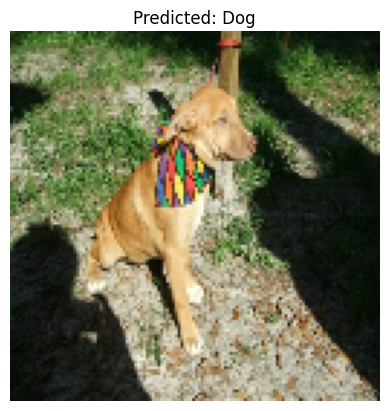

In [39]:
display(0)